## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [81]:
calibration_folder = './camera_cal'
output_folder = './output_images'

### Extracting Points

In [62]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
full_path = calibration_folder + '/calibration*.jpg'
images = glob.glob(full_path)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)

cv2.destroyAllWindows()



### Calibrating

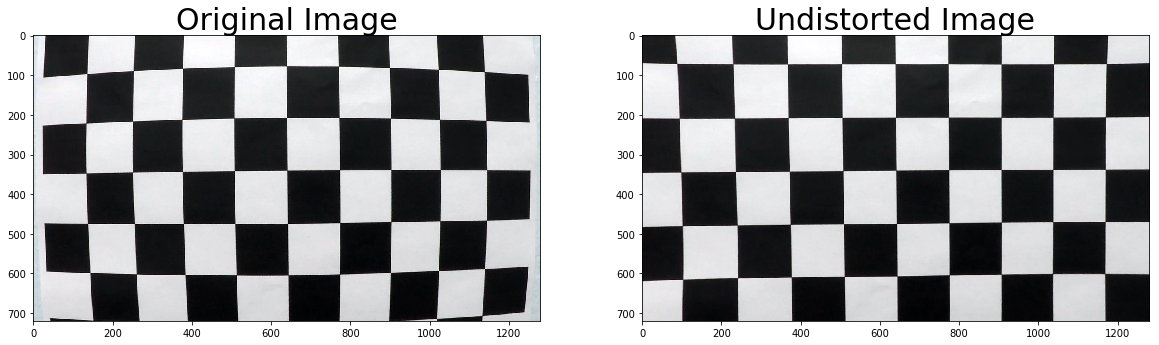

In [63]:
import pickle
%matplotlib inline

# Test undistortion on an image
test_image_path = calibration_folder + '/calibration1.jpg'
img = cv2.imread(test_image_path)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
undistort_path = calibration_folder + '/test_undist.jpg'
cv2.imwrite(undistort_path,dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

pickle_path = calibration_folder + '/wide_dist_pickle.p'
pickle.dump( dist_pickle, open( pickle_path, "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Lane Detection Pipeline

### Utils

In [102]:
import matplotlib.pyplot as plt

def plot_image(index, img, title, mode = 'RBG', points = []):   
    if (mode is 'BGR'):
        aux_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        aux_img = img
    
    plt.figure(index)
    
    if (mode is 'GRAY'):
        plt.imshow(aux_img, cmap='gray')
    else:
        plt.imshow(aux_img)
        
    plt.title(title, fontsize=30)
    
    for p in points:
        x = p[0]
        y = p[1]
        plt.plot(x,y, "o")
    #cv2.imshow(title,aux_img)

def squared_points(src, top = 0):
    bottom_left = src[0]
    bottom_right = src[1]
    top_left = src[2]
    top_right = src[3]
    
    new_bottom_left = [300,top]
    new_bottom_right = [1000,top]
    #new_top_left = [bottom_left[0],top_left[1]]
    #new_top_right = [bottom_right[0],top_right[1]]
    new_top_left = [bottom_left[0],top]
    new_top_right = [bottom_right[0],top]
    
    squared = []
    squared.append(new_bottom_left)
    squared.append(new_bottom_right)
    squared.append(new_top_left)
    squared.append(new_top_right)

    return squared
    

### Image PlayGround

In [103]:
import numpy as np

def undistort_image(distorted_img, camera_matrix, distortion_coeffs):
    return cv2.undistort(distorted_img, camera_matrix, distortion_coeffs, None, camera_matrix)


def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def to_saturation(img, thresh = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    dx = 1
    dy = 0
    if orient == 'y':
        dx = 0
        dy = 1
    
    sobel = cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def sobel_magnitude(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel)
    #abs_sobel = np.absolute(sobelx+sobely)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

def sobel_direction(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_combined(img):
    ksize = 3
    gradx = sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 255))
    grady = sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(100, 255))
    mag_binary = sobel_magnitude(img, sobel_kernel=ksize, mag_thresh=(30, 255))
    dir_binary = sobel_direction(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


    return combined

def perspective_transform_full_process(img, src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped;

def perspective_transform(img, src,dst, M, image_size):
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped;



### Load Test Image

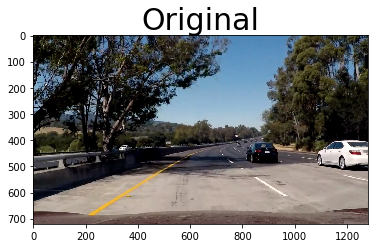

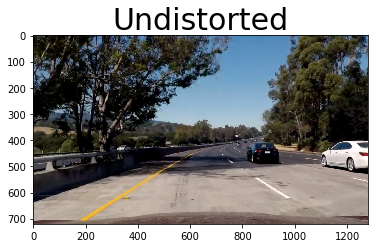

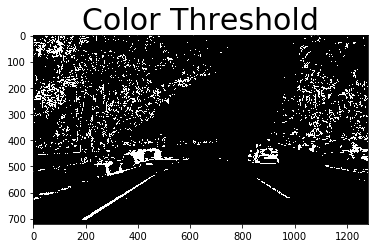

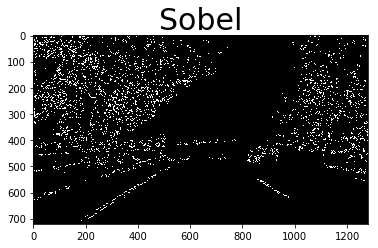

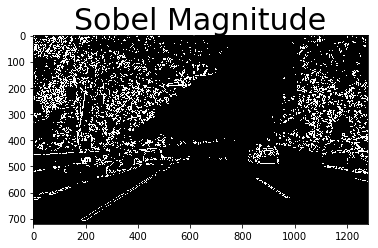

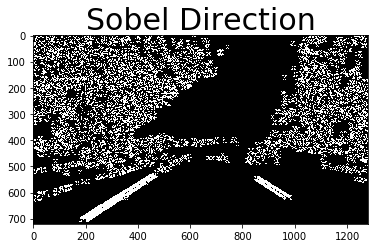

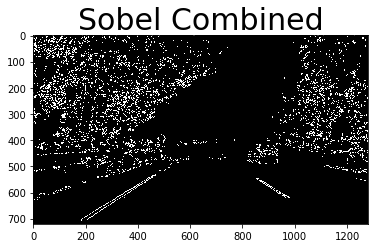

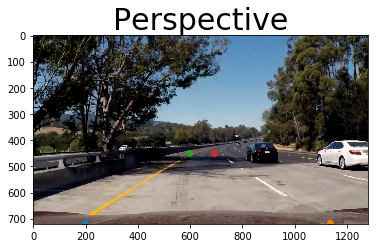

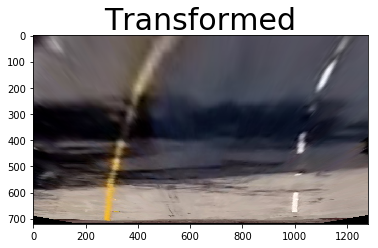

In [104]:
import cv2
import pickle

test_image_folder = './test_images'
#test_image_path = test_image_folder + '/straight_lines1.jpg'
test_image_path = test_image_folder + '/test5.jpg'
test_image = cv2.imread(test_image_path)

calibration_folder = './camera_cal'
pickle_path = calibration_folder + '/wide_dist_pickle.p'
dist_pickle = pickle.load( open( pickle_path, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

plot_image(0,test_image, 'Original', mode = 'BGR')

undistorted_img = undistort_image(test_image, mtx, dist)

plot_image(1,undistorted_img, 'Undistorted', mode = 'BGR')
cv2.imwrite(output_folder + '/undistorted_road.png' ,undistorted_img)

color_threshold = to_saturation(undistorted_img, thresh = (170, 255))
plot_image(2,color_threshold, 'Color Threshold', mode = 'GRAY')

sobel = sobel_thresh(color_threshold, orient='x', sobel_kernel=3, thresh=(20, 100))

plot_image(3,sobel, 'Sobel', mode = 'GRAY')

sobel_mag = sobel_magnitude(color_threshold, sobel_kernel=3, mag_thresh=(100, 255))
plot_image(4,sobel_mag, 'Sobel Magnitude', mode = 'GRAY')


sobel_dir = sobel_direction(color_threshold, sobel_kernel=15, thresh=(0.7, 1.3))
plot_image(5,sobel_dir, 'Sobel Direction', mode = 'GRAY')

sobel_comb = sobel_combined(color_threshold)
plot_image(6,sobel_comb, 'Sobel Combined', mode = 'GRAY')

# = [[280,670],[1034, 670],[560,475],[725,475]]
p = [[197,715],[1136, 715],[594,447],[691,447]]

plot_image(7,test_image, 'Perspective', mode = 'BGR', points = p)


src = np.float32(p)
#dest = np.float32([[280,670],[1034, 670],[280,0],[1034,0]])
#dest = np.float32([p[0],p[1],[280,0],[1034,0]])
#dest = np.float32(squared_points(src, top = 0))

bottom_left = src[0]
bottom_right = src[1]
top_left = src[2]
top_right = src[3]
    
new_bottom_left = [300,bottom_left[1]]
new_bottom_right = [1000,bottom_right[1]]
new_top_left = [300,0]
new_top_right = [1000,0]
    
dest = []
dest.append(new_bottom_left)
dest.append(new_bottom_right)
dest.append(new_top_left)
dest.append(new_top_right)
dest = np.float32(dest)


perspective_trasformed = perspective_transform_full_process(test_image, src, dest)
plot_image(8,perspective_trasformed, 'Transformed', mode = 'BGR')




### Test full Preprocess

In [134]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def image_preprocess(img, camera_matrix, distortion_coeffs, M, image_size):
    undistorted_img = undistort_image(test_image, camera_matrix, distortion_coeffs)
    thresholded_image, binary = pipeline(img, s_thresh=(200, 255), r_thresh = (200, 255), sx_thresh=(20, 100))
    perspective_trasformed = perspective_transform(binary, src, dest, M, image_size)
    return perspective_trasformed

def thresh(img, thresh_min, thresh_max):
        ret = np.zeros_like(img)
        ret[(img >= thresh_min) & (img <= thresh_max)] = 1
        return ret

def pipeline_old(img, s_thresh=(170, 255), r_thresh = (200, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    r_channel = img[:,:,0]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = thresh(scaled_sobel, sx_thresh[0], sx_thresh[1])
    
    # Threshold color s_channel
    s_binary = thresh(s_channel, s_thresh[0], s_thresh[1])
    
    r_binary = thresh(r_channel, r_thresh[0], r_thresh[1])
    
    color_binary = np.dstack((r_binary, sxbinary, s_binary))

        
    combined = np.zeros_like(s_binary)
    combined[((sxbinary == 1) | ((s_binary == 1) & (r_binary == 1)))] = 1

    return color_binary, combined

def pipeline(img, s_thresh=(170, 255), r_thresh = (200, 255), sx_thresh=(20, 100)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    t_yellow_H = thresh(H,10,30)
    t_yellow_S = thresh(S,50,255)
    t_yellow_V = thresh(V,150,255)

    t_white_R = thresh(R,225,255)
    t_white_V = thresh(V,230,255)
    
    yellow = np.zeros_like(H)
    white  = np.zeros_like(H)
    combined = np.zeros_like(H)
    
    yellow[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
    white[(t_white_R==1)|(t_white_V==1)] = 1
    
    combined[(yellow ==1)|(white ==1)] = 1
    
    color_binary = np.dstack((np.zeros_like(H), yellow*255, white*255))
    
    #b[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
    #b[(t_white_R==1)|(t_white_V==1)] = 1
    return color_binary, combined

[[197, 715], [1136, 715], [594, 447], [691, 447]]


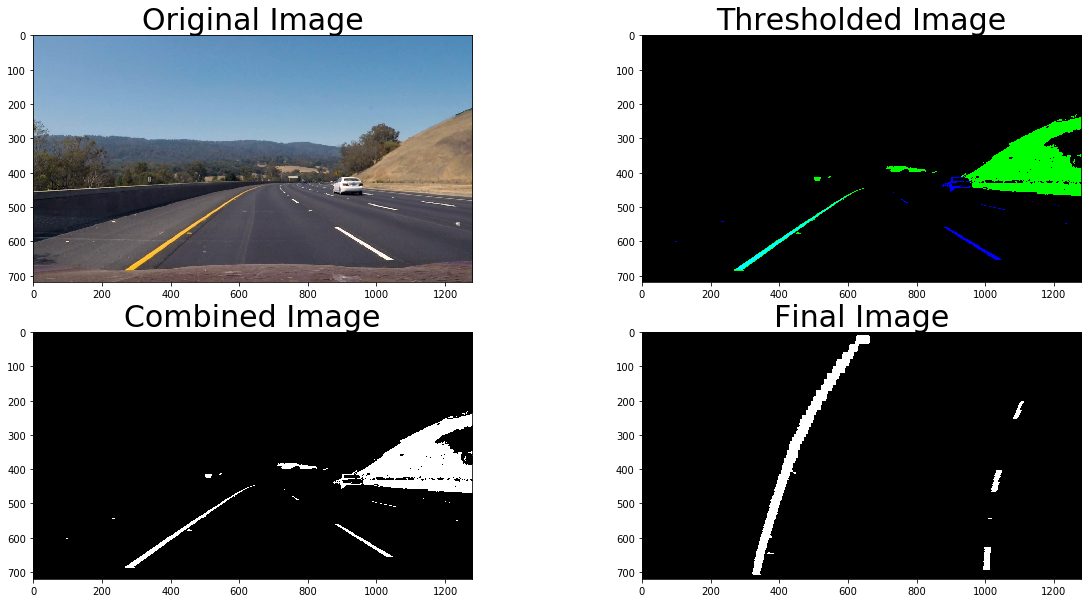

In [140]:
test_image_folder = './test_images'
test_image_path = test_image_folder + '/test3.jpg'
test_image = mpimg.imread(test_image_path)

calibration_folder = './camera_cal'
pickle_path = calibration_folder + '/wide_dist_pickle.p'
dist_pickle = pickle.load( open( pickle_path, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

print(p)
src = np.float32(p)
bottom_left = src[0]
bottom_right = src[1]
top_left = src[2]
top_right = src[3]
    
new_bottom_left = [300,bottom_left[1]]
new_bottom_right = [1000,bottom_right[1]]
new_top_left = [300,0]
new_top_right = [1000,0]
    
dest = []
dest.append(new_bottom_left)
dest.append(new_bottom_right)
dest.append(new_top_left)
dest.append(new_top_right)
dest = np.float32(dest)

M = cv2.getPerspectiveTransform(src, dest)
Minv = cv2.getPerspectiveTransform(dest, src)
img_size = (test_image.shape[1], test_image.shape[0])

result, result_binary = pipeline(test_image, s_thresh=(200, 255), r_thresh = (200, 255), sx_thresh=(20, 100))
final_result = image_preprocess(test_image, mtx, dist, M, img_size)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Thresholded Image', fontsize=30)
ax3.imshow(result_binary, cmap = 'gray')
ax3.set_title('Combined Image', fontsize=30)
ax4.imshow(final_result, cmap = 'gray')
ax4.set_title('Final Image', fontsize=30)

## Lane Detection

### Playground

### Sliding Window

374
1008


(720, 0)

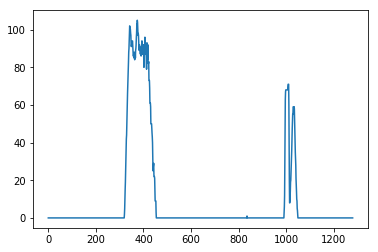

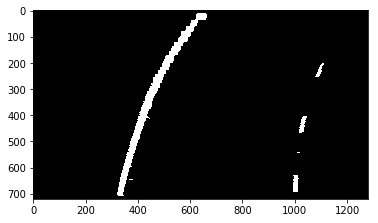

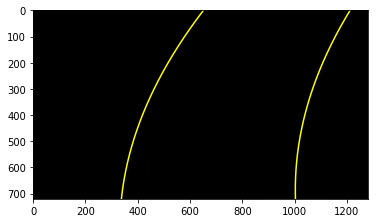

In [142]:
import numpy as np

binary_warped = final_result

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

plt.figure(0)
plt.plot(histogram)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(leftx_base)
print(rightx_base)


plt.figure(1)
plt.imshow(out_img)


# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
plt.figure(2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Polynomial

(720, 0)

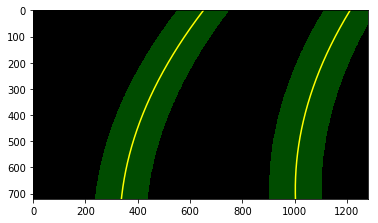

In [143]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Curvature

In [165]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
print(y_eval)

# Define conversions in x and y from pixels space to meters
#ym_per_pix = 30/720 # meters per pixel in y dimension
#xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_c = left_fit[0] * y_eval** 2 + left_fit[1] * y_eval + left_fit[2]
right_c = right_fit[0] * y_eval ** 2 + right_fit[1] * y_eval + right_fit[2]
width = right_c - left_c
print(width)

ym_per_pix = (3*7)/720 # meters per pixel in y dimension
xm_per_pix = 3.7 / width

print(ploty.shape)
print(leftx.shape)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radius of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
curvature = (left_curverad+right_curverad)/2

print(left_curverad, 'm', right_curverad, 'm')

center_img = binary_warped.shape[1]/2
left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
center_lane = (left_x + right_x)/2
diff_pixels = center_img - center_lane
diff_meters = diff_pixels*xm_per_pix
print(left_x, right_x)
print(center_img, center_lane,diff_pixels)

print(diff_pixels*xm_per_pix)

1106.79833707 1124.5819657
719.0
665.247795185
(720,)
(21818,)
166.612275748 m 171.783532163 m
337.847453481 1003.09524867
640.0 670.471351074 -30.4713510735
-0.169476696936


### Draw In image

Radius of Curvature = 169.20 (m)
Vehicle is 0.17 (m) left of center


True

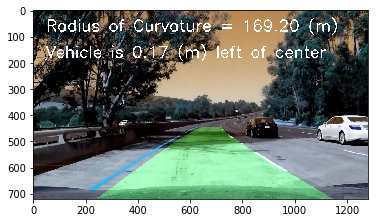

In [166]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(test_image, 1, newwarp, 0.3, 0)


radius_str = 'Radius of Curvature = ' + "{:3.2f}".format(curvature) + ' (m)'
side_str = "right" if diff_meters>0 else "left"
diff_str = "{:3.2f}".format(abs(diff_meters))
position_str = 'Vehicle is ' + diff_str + ' (m) ' + side_str + ' of center'
print(radius_str)
print(position_str)


font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,radius_str,(50, 80), font, 2,(255,255,255),3)
cv2.putText(result,position_str,(50, 180), font, 2,(255,255,255),3)

rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
cv2.imwrite(output_folder + '/final_result.png' ,result)

## Final PipeLine

In [151]:
import numpy as np


class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def evaluate(self, y):
        coef_2 = self.current_fit[0]
        coef_1 = self.current_fit[1]
        coef = self.current_fit[2]
        val = coef_2*y**2 + coef_1*y + coef
        return val

In [173]:
import numpy as np
import cv2

class LaneDetector:
    def __init__(self, camera_matrix, distorsion_coefficients):
        self.left_line = Line()
        self.right_line = Line()
        self.camera_matrix = camera_matrix
        self.distorsion_coefficients = distorsion_coefficients
        self.frame_count = 0
        self.saturation_threshold = (200, 255)
        self.red_threshold = (200, 255)
        self.sobel_x_thershold = (20, 100)
        self.cache_transform_indices()
        
        
    def cache_transform_indices(self):
        p = [[197,715],[1136, 715],[594,447],[691,447]]
        src = np.float32(p)
        bottom_left = src[0]
        bottom_right = src[1]
        top_left = src[2]
        top_right = src[3]
    
        new_bottom_left = [300,bottom_left[1]]
        new_bottom_right = [1000,bottom_right[1]]
        new_top_left = [300,0]
        new_top_right = [1000,0]
    
        dest = []
        dest.append(new_bottom_left)
        dest.append(new_bottom_right)
        dest.append(new_top_left)
        dest.append(new_top_right)
        dest = np.float32(dest)

        self.M = cv2.getPerspectiveTransform(src, dest)
        self.Minv = cv2.getPerspectiveTransform(dest, src)
        return None
    
    def detect(self, image):
        self.raw_image = image
        self.frame_count += 1
        self.img_size = (image.shape[1], image.shape[0])

        #result = np.copy(image)
        result = self.undistort(image)
        threshold_3channels, result = self.threshold(result)
        result = self.perspective_transform(result)
        
        if (self.frame_count < 3):
            self.detect_with_window(result)
        else:
            self.detect_with_poly(result)
                
        self.calculate_curvature()
        
        final = self.draw_final_image(result, image)
        return final
        #return result
        #return self.binary_to_RGB(result)
    
    def undistort(self, img):
        mtx = self.camera_matrix
        dist = self.distorsion_coefficients
        #print(mtx, dist)
        result = cv2.undistort(img, mtx, dist, None, mtx)
        #result = np.copy(img)
        return result
    
    def thresh(img, thresh_min, thresh_max):
        ret = np.zeros_like(img)
        ret[(img >= thresh_min) & (img <= thresh_max)] = 1
        return ret
    
    def threshold(self, img):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]

        R = img[:,:,0]
        G = img[:,:,1]
        B = img[:,:,2]

        t_yellow_H = thresh(H,10,30)
        t_yellow_S = thresh(S,50,255)
        t_yellow_V = thresh(V,150,255)

        t_white_R = thresh(R,225,255)
        t_white_V = thresh(V,230,255)

        yellow = np.zeros_like(H)
        white  = np.zeros_like(H)
        combined = np.zeros_like(H)

        yellow[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
        white[(t_white_R==1)|(t_white_V==1)] = 1

        combined[(yellow ==1)|(white ==1)] = 1

        color_binary = np.dstack((np.zeros_like(H), yellow*255, white*255))

        return color_binary, combined
      
    
    def perspective_transform(self, img):
        M = self.M
        img_size = self.img_size
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        return warped
    
    def binary_to_RGB(self, img_binary):
        binary_in255 = img_binary*255
        out = np.dstack((binary_in255, binary_in255, binary_in255))
        return out
    
    def detect_with_window(self, img):
        binary_warped = img
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 4) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
               
        # Generate x and y values for plotting
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
        
        self.ploty = ploty

        self.left_line.current_fit = left_fit
        self.right_line.current_fit = right_fit
        
        self.left_line.allx = leftx
        self.left_line.ally = lefty

        self.right_line.allx = rightx
        self.right_line.ally = righty
        
        self.left_line.recent_xfitted = left_fitx
        self.right_line.recent_xfitted = right_fitx
        
        return out_img
    
    def detect_with_poly(self, img):
        left_fit = self.left_line.current_fit
        right_fit = self.right_line.current_fit
                
        binary_warped = img
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
        self.ploty = ploty

        self.left_line.current_fit = left_fit
        self.right_line.current_fit = right_fit
        
        self.left_line.allx = leftx
        self.left_line.ally = lefty

        self.right_line.allx = rightx
        self.right_line.ally = righty
        
        self.left_line.recent_xfitted = left_fitx
        self.right_line.recent_xfitted = right_fitx


    def calculate_curvature(self):
        ploty = self.ploty
        left_fit = self.left_line.current_fit
        right_fit = self.right_line.current_fit
        
        leftx = self.left_line.allx
        lefty = self.left_line.ally
        
        rightx = self.right_line.allx
        righty = self.right_line.ally
        
        left_fitx = self.left_line.recent_xfitted
        right_fitx = self.right_line.recent_xfitted
        
        y_eval = np.max(ploty)
        
        
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        #print(left_curverad, right_curverad)

        # Define conversions in x and y from pixels space to meters
        #ym_per_pix = 30/720 # meters per pixel in y dimension
        #xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        left_c = left_fit[0] * y_eval** 2 + left_fit[1] * y_eval + left_fit[2]
        right_c = right_fit[0] * y_eval ** 2 + right_fit[1] * y_eval + right_fit[2]
        width = right_c - left_c
        ym_per_pix = (3*7)/720 # meters per pixel in y dimension
        xm_per_pix = 3.7 / width

        #print(ploty.shape)
        #print(leftx.shape)
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radius of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        curvature = (left_curverad+right_curverad)/2

        #print(left_curverad, 'm', right_curverad, 'm')

        #center_img = binary_warped.shape[1]/2
        #print(self.img_size)
        center_img = self.img_size[0]/2
        left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        center_lane = (left_x + right_x)/2
        diff_pixels = center_img - center_lane
        diff_meters = diff_pixels*xm_per_pix
        
        self.left_line.radius_of_curvature = left_curverad
        self.right_line.radius_of_curvature = right_curverad
        
        self.radius_of_curvature = curvature
        self.center_lane = center_lane
        self.diff_meters = diff_meters
        #print(left_x, right_x)
        #print(center_img, center_lane,diff_pixels)

        #print(diff_pixels*xm_per_pix)
        return None
    
    def draw_final_image(self, binary, original):
        # Create an image to draw the lines on
        binary_warped = binary
        left_fitx = self.left_line.recent_xfitted
        right_fitx = self.right_line.recent_xfitted
        ploty = self.ploty
        curvature = self.radius_of_curvature
        diff_meters = self.diff_meters


         
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        #print(color_warp.shape)
        #print(pts)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        Minv = self.Minv
        newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)

        curvature_str = "{:3.2f}".format(curvature)
        radius_str = 'Radius of Curvature = ' + curvature_str + ' (m)'
        side_str = "right" if diff_meters>0 else "left"
        diff_str = "{:3.2f}".format(abs(diff_meters))
        position_str = 'Vehicle is ' + diff_str + ' (m) ' + side_str + ' of center'
        frame_str = 'Frame: ' + str(self.frame_count)

        #print(radius_str)
        #print(position_str)


        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result,radius_str,(50, 80), font, 2,(255,255,255),3)
        cv2.putText(result,position_str,(50, 180), font, 2,(255,255,255),3)
        cv2.putText(result,frame_str,(50, 280), font, 2,(255,255,255),3)

        return result


        #plt.imshow(result)

        
    

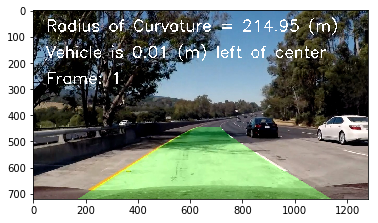

In [174]:
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


calibration_folder = './camera_cal'
pickle_path = calibration_folder + '/wide_dist_pickle.p'
dist_pickle = pickle.load( open( pickle_path, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

test_image_folder = './test_images'
test_image_path = test_image_folder + '/test5.jpg'
test_image = mpimg.imread(test_image_path)

lane_detector = LaneDetector(mtx, dist)
r = lane_detector.detect(test_image)
plt.imshow(r)

In [175]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [177]:
video_output = 'out_project_video.mp4'
#clip1 = VideoFileClip("project_video_shortest.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(15, 30)
clip1 = VideoFileClip("project_video.mp4")


lane_detector = LaneDetector(mtx, dist)

#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip = clip1.fl_image(lane_detector.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:22<00:00,  9.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

Wall time: 2min 23s
